# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy

In [1]:
#Import all necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [2]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [3]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [4]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [5]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
255753,2017-06-05 15:26:00,2017-06-05 15:27:00,3152,3152,11907,Indego30,"40th & Baltimore, Trolley Portal","40th & Baltimore, Trolley Portal"
255755,2017-06-05 15:26:00,2017-06-05 15:27:00,3000,3000,11907,Indego30,Virtual Station,Virtual Station
256143,2017-06-05 17:26:00,2017-06-05 17:31:00,3152,3024,11907,Walk-up,"40th & Baltimore, Trolley Portal","43rd & Chester, Clark Park"
256148,2017-06-05 17:26:00,2017-06-05 17:31:00,3000,3024,11907,Walk-up,Virtual Station,"43rd & Chester, Clark Park"
258113,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3000,5314,Indego30,Municipal Services Building Plaza,Virtual Station
258115,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East


The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [6]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [7]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [8]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [9]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id


In [10]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793
...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969


In [11]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
255784,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East,39.953781,-75.163742,NaN,NaN
613438,2017-10-05 08:35:00,2017-10-05 08:47:00,3111,3107,5306,Indego30,"Parkside & Belmont, Case Building",33rd & Reservoir,NaN,NaN,39.982029,-75.18866
613848,2017-10-05 10:31:00,2017-10-05 10:53:00,3095,3111,5329,Indego30,29th & Diamond,"Parkside & Belmont, Case Building",39.987709,-75.180519,NaN,NaN


In [12]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [13]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [14]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
699155,2017-11-05 01:35:00,2017-11-05 01:03:00,3118,3111,6694,Indego30,"46th Street Station, MFL","Parkside & Belmont, Case Building",39.958660,-75.213226,39.977791,-75.213226,-1 days +23:28:00,11,44,6,5,1
699158,2017-11-05 01:39:00,2017-11-05 01:35:00,3066,3066,2551,Indego30,19th & Lombard,19th & Lombard,39.945610,-75.173477,39.945610,-75.173477,-1 days +23:56:00,11,44,6,5,1
699163,2017-11-05 01:51:00,2017-11-05 01:20:00,3157,3041,11750,Indego30,"8th & Mifflin, Bok Building","Girard Station, MFL",39.925449,-75.159538,39.968491,-75.135460,-1 days +23:29:00,11,44,6,5,1


In [15]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [16]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
682,2017-01-01 18:19:00,2017-01-03 08:04:00,3072,3125,5354,Walk-up,Front & Carpenter,15th & South,39.934448,-75.145409,39.943909,-75.167351,1 days 13:45:00,1,52,6,1,18
20987,2017-01-23 15:19:00,2017-01-24 16:14:00,3038,3028,2492,Indego30,The Children's Hospital of Philadelphia (CHOP),4th & Bainbridge,39.947811,-75.194092,39.940609,-75.149582,1 days 00:55:00,1,4,0,23,15
24873,2017-01-26 17:31:00,2017-01-28 10:00:00,3021,3109,5185,Indego30,18th & JFK,Parkside & Girard,39.953899,-75.169022,39.974861,-75.205238,1 days 16:29:00,1,4,3,26,17
27216,2017-01-28 15:46:00,2017-01-30 08:01:00,3012,3034,5255,Walk-up,21st & Catharine,11th & Reed,39.942181,-75.177467,39.933151,-75.162483,1 days 16:15:00,1,4,5,28,15
32762,2017-02-02 09:45:00,2017-02-03 17:59:00,3054,3021,5125,Indego30,Rodin Museum,18th & JFK,39.962502,-75.174202,39.953899,-75.169022,1 days 08:14:00,2,5,3,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735895,2017-11-25 12:12:00,2017-11-27 07:31:00,3112,3020,11894,Indego30,48th & Spruce,University City Station,39.953732,-75.218246,39.949219,-75.190361,1 days 19:19:00,11,47,5,25,12
749711,2017-12-02 13:00:00,2017-12-03 14:12:00,3040,3073,11928,Walk-up,17th & Spring Garden,9th & Spring Garden,39.962891,-75.166061,39.961430,-75.152420,1 days 01:12:00,12,48,5,2,13
763091,2017-12-11 11:46:00,2017-12-12 13:15:00,3018,3037,3367,Indego30,12th & Filbert,Pennsylvania Convention Center,39.952728,-75.159790,39.954239,-75.161377,1 days 01:29:00,12,50,0,11,11
768955,2017-12-15 19:27:00,2017-12-17 16:32:00,3026,3072,11932,Indego30,2nd & South,Front & Carpenter,39.941380,-75.145638,39.934448,-75.145409,1 days 21:05:00,12,50,4,15,19


In [17]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour


In [18]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,12,52,6,31,23


### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [19]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [20]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [21]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

,date_time,max_temp,min_temp,precip


We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [22]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
43785,NaT,NaN,NaN,NaN


In [23]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [24]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [25]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [26]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

,date_time,max_temp,min_temp,precip


,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,6.1,6.1,0.0
1,2017-01-01 01:00:00,6.1,6.1,0.0
2,2017-01-01 02:00:00,6.7,6.7,0.0
3,2017-01-01 03:00:00,7.2,7.2,0.0
4,2017-01-01 04:00:00,7.8,7.8,0.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-8.9,-8.9,0.0
8756,2017-12-31 20:00:00,-8.9,-8.9,0.0
8757,2017-12-31 21:00:00,-9.4,-9.4,0.0
8758,2017-12-31 22:00:00,-10.0,-10.0,0.0


All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

## KPI Revenue

For this KPI we will calculate the revenue for every trip based on the given user_type. We can not calculate the revenue per user, <br>
since we do not have any information about specific users via a user_id, since that does not exist in our dataset.

In [27]:
# Prepare new dataframe for calculating the revenue
df_phil_revenue = df_philadelphia_cleaned[['end_time', 'trip_duration', 'user_type', 'weekday']].copy(deep=True)
df_phil_revenue.loc[:, 'trip_duration'] = df_phil_revenue['trip_duration'].dt.seconds / 60
df_phil_revenue.rename(columns={'trip_duration': 'trip_duration_in_minutes'}, inplace=True)
# Since we have full minutes without any remainder we can convert the trip_duration in minutes to int
df_phil_revenue['trip_duration_in_minutes'] = df_phil_revenue['trip_duration_in_minutes'].astype(int)
# The dataset from above needs to be resetted, so it doesnt need to be done here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_phil_revenue.reset_index(drop = True, inplace =True)
df_phil_revenue

,end_time,trip_duration_in_minutes,user_type,weekday
0,2017-01-01 00:16:00,11,Indego30,6
1,2017-01-01 00:57:00,36,Walk-up,6
2,2017-01-01 00:57:00,35,Walk-up,6
3,2017-01-01 00:39:00,12,Indego30,6
4,2017-01-01 00:36:00,8,Walk-up,6
...,...,...,...,...
782220,2017-12-31 23:33:00,28,Indego30,6
782221,2018-01-01 11:03:00,712,Indego30,6
782222,2017-12-31 23:25:00,7,Indego30,6
782223,2017-12-31 23:40:00,1,Indego30,6


In [28]:
# All user_types in our dataset
print(df_phil_revenue['user_type'].unique())

['Indego30' 'Walk-up' 'IndegoFlex' 'One Day Pass' 'Two Day Pass'
 'Indego365']


Prices for the specific "user_type" in our dataframe (as seen above) were found through the help of the Wayback Machine in 2017:
- Walk-up: $4 per 30 minutes
- IndegoFlex: $4 per hour
- One Day Pass: Unlimited 30 minute trips + $2 per 30 minutes for trips over 30 minutes
- Two Day Pass: Unlimited 30 minute trips + $2 per 30 minutes for trips over 30 minutes
- Indego365: Unlimited 1 hour trips + $4 per hour for trips over 1 hour
- Indego30: Unlimited 1 hour trips + $4 per hour for trips over 1 hour

Since we were not able to find any information regarding the "Two Day Pass" we assumed that the same pricing conditions apply from the "One Day Pass" to the "Two Day Pass".

In [29]:
# Calculation of every user_type pricing condition and saving it in a new column called "revenue_in_$"
for i in range(0, len(df_phil_revenue)):
    # We need the duration and the user_type beforehand to determine the different pricing conditions 
    duration = df_phil_revenue.at[i, 'trip_duration_in_minutes']
    price_type = df_phil_revenue.at[i, 'user_type']
    if(price_type == 'Walk-up'):
        df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'])/30))
    elif(price_type == 'IndegoFlex'):
        df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'])/60))
    elif(price_type == 'One Day Pass' or price_type == 'Two Day Pass'):
        # Since there are unlimited 30 minute trips, we can just give them 0$ revenue as a result
        if(duration <= 30):
            df_phil_revenue.at[i, 'revenue_in_$'] = 0
        else:
            # - 30 needs to be added to the calculation, so the first half an hour doesnt count in
            df_phil_revenue.at[i, 'revenue_in_$'] = 2*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'] - 30)/30))
    elif(price_type == 'Indego365' or price_type == 'Indego30'):
        # Since there are unlimited 60 minute trips, we can just give them 0$ revenue as a result
        if(duration <= 60):
            df_phil_revenue.at[i, 'revenue_in_$'] = 0
        else:
            # - 60 needs to be added to the calculation, so the first hour doesnt count in
            df_phil_revenue.at[i, 'revenue_in_$'] = 4*(np.ceil((df_phil_revenue.at[i, 'trip_duration_in_minutes'] - 60)/60))

# Since we dont have any values with remainder, we can also convert the revenue into an int for convenience, and drop the trip duration
df_phil_revenue['revenue_in_$'] = df_phil_revenue['revenue_in_$'].astype(int)
df_phil_revenue.drop('trip_duration_in_minutes', axis = 1, inplace = True)

In [30]:
# Finished dataframe with all revenue calculations done
df_phil_revenue

,end_time,user_type,weekday,revenue_in_$
0,2017-01-01 00:16:00,Indego30,6,0
1,2017-01-01 00:57:00,Walk-up,6,8
2,2017-01-01 00:57:00,Walk-up,6,8
3,2017-01-01 00:39:00,Indego30,6,0
4,2017-01-01 00:36:00,Walk-up,6,4
...,...,...,...,...
782220,2017-12-31 23:33:00,Indego30,6,0
782221,2018-01-01 11:03:00,Indego30,6,44
782222,2017-12-31 23:25:00,Indego30,6,0
782223,2017-12-31 23:40:00,Indego30,6,0


In [31]:
# Creating a new dataframe for easier usage later on for the plots
df_phil_revenue_plt = df_phil_revenue.copy()

# Setting the end_time as our new index to resample 
df_phil_revenue_plt.sort_values(['end_time'], inplace = True)
df_phil_revenue_plt.set_index('end_time', inplace = True)

#Finished dataframe for plotting purposes
df_phil_revenue_plt

,user_type,weekday,revenue_in_$
end_time,,,
2017-01-01 00:16:00,Indego30,6,0
2017-01-01 00:36:00,Walk-up,6,4
2017-01-01 00:36:00,Walk-up,6,4
2017-01-01 00:39:00,Indego30,6,0
2017-01-01 00:40:00,Indego30,6,0
...,...,...,...
2017-12-31 23:33:00,Indego30,6,0
2017-12-31 23:40:00,Indego30,6,0
2017-12-31 23:55:00,Indego30,6,0


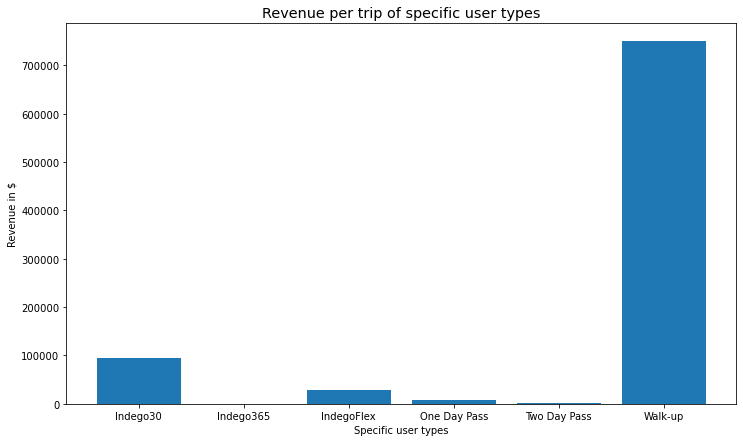

In [32]:
# Plotting revenue per trip based on user type
df_phil_revenue_type = df_phil_revenue_plt.copy()

# Resample based on user_type and calculate the sum of each user_type
df_phil_revenue_type = df_phil_revenue_type.groupby(['user_type']).sum().reset_index()

# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_revenue_type['user_type'], df_phil_revenue_type['revenue_in_$'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('Specific user types', size = 'medium')
plt.ylabel('Revenue in $', size = 'medium')
plt.title('Revenue per trip of specific user types', size = 'x-large')
plt.show()

The most income as seen in the plot above is created by the user_type "Walk-up", since this user_type also doesnt have any kind of free one hour or half an hour usage, <br>
like "Indego30" or "Indego365". The "Two Day Pass" was only availabe in the month of August and "Indego365 since the month of october, hence why it has such a low revenue.

In [33]:
# Plotting the revenue for every month
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to a monthly format
df_phil_revenue_plt_monthly = df_phil_revenue_plt.resample('M').sum(numeric_only=True)
df_phil_revenue_plt_monthly.index.rename('months', inplace=True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_monthly.index, y = 'revenue_in_$', data = df_phil_revenue_plt_monthly)
plt.title('Revenue per trip for every month')
plt.show()

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [34]:
# Plotting the revenue for every week
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to a weekly format
df_phil_revenue_plt_weekly = df_phil_revenue_plt.resample('W').sum(numeric_only=True)
df_phil_revenue_plt_weekly.index.rename('weeks', inplace = True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_weekly.index, y = 'revenue_in_$', data = df_phil_revenue_plt_weekly)
plt.title('Revenue per trip for every week')
plt.show()

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [ ]:
# Plotting the normalized revenue for every week in comparisent to the temperature
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Preparing weather data
df_phil_revenue_weather = df_weather_2017.copy()
df_phil_revenue_weather.drop('max_temp', axis = 1, inplace = True)
df_phil_revenue_weather.drop('precip', axis = 1, inplace = True)
df_phil_revenue_weather.set_index('date_time', inplace = True)
df_phil_revenue_weather = df_phil_revenue_weather.resample('W').mean()

# Normalizing data
df_phil_revenue_plt_weekly['normalized_revenue_in_$'] = (df_phil_revenue_plt_weekly[['revenue_in_$']] - df_phil_revenue_plt_weekly[['revenue_in_$']].min(axis=0)) / (df_phil_revenue_plt_weekly[['revenue_in_$']].max(axis=0) - df_phil_revenue_plt_weekly[['revenue_in_$']].min(axis=0))
df_phil_revenue_weather['normalized_min_temp'] = (df_phil_revenue_weather[['min_temp']] - df_phil_revenue_weather[['min_temp']].min(axis=0)) / (df_phil_revenue_weather[['min_temp']].max(axis=0) - df_phil_revenue_weather[['min_temp']].min(axis=0))

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_weekly.index, y = 'normalized_revenue_in_$', data = df_phil_revenue_plt_weekly)
plot_temp = sns.lineplot(x = df_phil_revenue_weather.index, y = 'normalized_min_temp', data = df_phil_revenue_weather)
ax.legend(['Revenue', 'Temperature'])
plt.title('Normalized revenue per trip for every week compared to normalized temperature')
plt.show()

In [ ]:
# Plotting the revenue for every day
sns.set(style='whitegrid', palette='colorblind', rc={'lines.linewidth': 2})

# Resampling the data to daily format
df_phil_revenue_plt_daily = df_phil_revenue_plt.resample('D').sum(numeric_only=True)
df_phil_revenue_plt_daily.index.rename('days', inplace = True)

#Plotting 
fig, ax = plt.subplots(figsize = (12,7))
plot_monthly = sns.lineplot(x = df_phil_revenue_plt_daily.index, y = 'revenue_in_$', data = df_phil_revenue_plt_daily)
plt.title('Revenue per trip for every day')
plt.show()

With the seasons changing and therefore rising temperature towards summer and decreasing temperature afterwards, <br>
we see the revenue first rise since its getting warmer and then falling off again after August, since its getting colder and <br>
the number of tourists starts to decline.

In [ ]:
# Plotting revenue based on weekday
df_phil_revenue_plt_weekday = df_phil_revenue_plt.copy()

# Data needs to be grouped by weekday and replaced with their corresponding weekday name
df_phil_revenue_plt_weekday = df_phil_revenue_plt_weekday.groupby(['weekday']).sum(numeric_only=True).reset_index()
df_phil_revenue_plt_weekday['weekday'].replace([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], inplace=True)

# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_revenue_plt_weekday['weekday'], df_phil_revenue_plt_weekday['revenue_in_$'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('weekdays', size = 'medium')
plt.ylabel('revenue in $', size = 'medium')
plt.title('Distribution of revenue per trip over the specific weekdays', size = 'x-large')
plt.show()

### Sum of rental duration

In [ ]:
# Preparing new dataframe with only trip_duration (converted to minutes) and the user_type
df_phil_rentDuration = df_philadelphia_cleaned[['trip_duration', 'user_type']].copy(deep=True)
df_phil_rentDuration.loc[:, 'trip_duration'] = df_phil_rentDuration['trip_duration'].dt.seconds / 60
df_phil_rentDuration.rename(columns={'trip_duration': 'trip_duration in minutes'}, inplace=True)
df_phil_rentDuration['trip_duration in minutes'] = df_phil_rentDuration['trip_duration in minutes'].astype(int)
# The dataset from above needs to be resetted, so it doesnt need to be done here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_phil_rentDuration.reset_index(drop = True, inplace = True)

# Final dataframe
df_phil_rentDuration

In [ ]:
# Group by on the user_type to find out the trip_duration for every user_type
df_phil_rentDuration = df_phil_rentDuration.groupby(['user_type']).sum().reset_index()

# Every user_type devided by the total amount of trip_duration
df_phil_rentDuration['percentage of trip_duration in minutes'] = df_phil_rentDuration['trip_duration in minutes'] / df_phil_rentDuration['trip_duration in minutes'].sum()
df_phil_rentDuration

In [ ]:
# Plotting
fig = plt.figure(figsize=(12,7))
plt.bar(df_phil_rentDuration['user_type'], df_phil_rentDuration['percentage of trip_duration in minutes'])

# Styling the plot
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.xlabel('Specific user types', size = 'medium')
plt.ylabel('Trip duration in minutes', size = 'medium')
plt.title('Trip duration of specific user types', size = 'x-large')
plt.show()

### Analysis of Total Rentals by user type

First we to look into the total distribution of rides by user types visualized by a pie chart.


In [35]:
# Count all rides per user type and sort descending
df_philadelphia_cleaned.groupby(["user_type"])["user_type"].count().reset_index(name = "n_rides").sort_values(by=['n_rides'], ascending=False)


,user_type,n_rides
0,Indego30,662593
5,Walk-up,99043
1,Indego365,6787
3,One Day Pass,6236
2,IndegoFlex,5972
4,Two Day Pass,1594


In [36]:
# Put data into Series to visualize as Pie Chart
slices = [662593, 99043, 6787, 6236, 5972, 1594]
user_types = ['Indego30','Walk-up', 'Indego365', 'OneDayPass', 'IndegoFlex', 'TwoDayPass']
cols = ['b','r','c','g', 'orange', 'black']

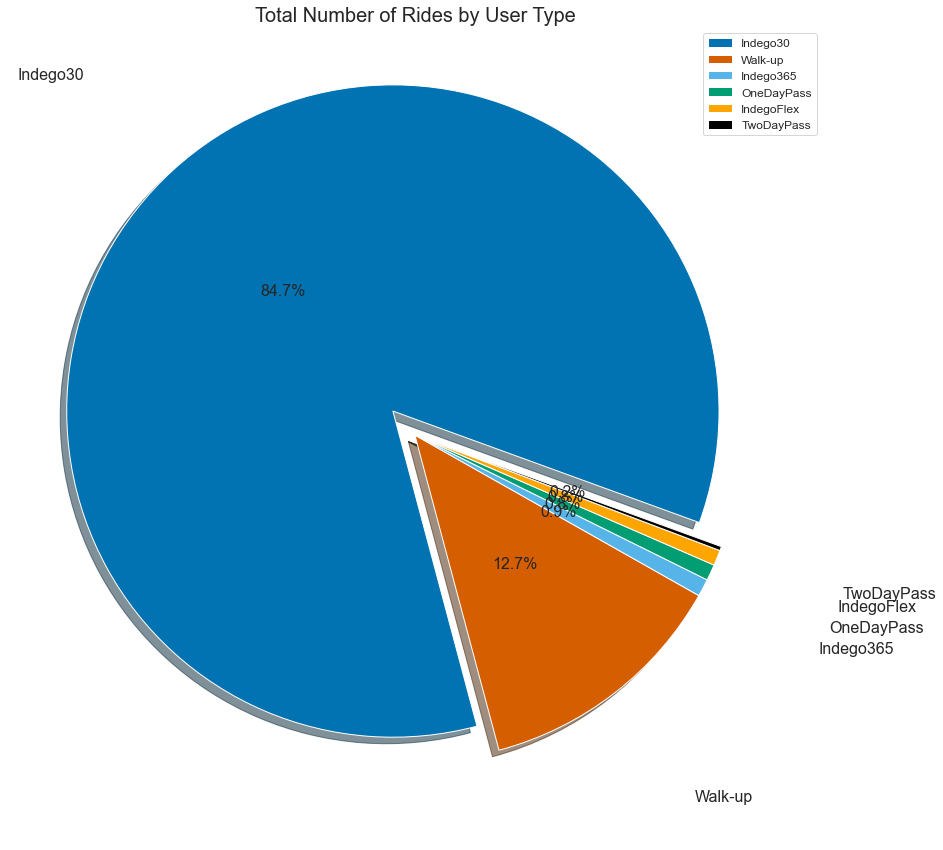

In [38]:
# Create pie chart
fig = plt.figure(figsize=(15,15))
plt.pie(slices,
labels =user_types,
labeldistance = 1.4,
pctdistance = 0.5,
colors = cols,
startangle = -20,
shadow = True,
explode =(0.1,0,0,0,0,0),
autopct ='%1.1f%%',
textprops={'fontsize': 16})
plt.title('Total Number of Rides by User Type', fontsize=20)
plt.legend(fontsize=12)


# Print the chart
plt.show()

#### Monthly Development of Rides by User Type

Next we take a look at monthly development of rides by user types to look for any seasonal patterns:

In [39]:
# Create Dataframe grouped by User types and months
df_months_usertype = df_philadelphia_cleaned.groupby(['month','user_type'])["user_type"].count().reset_index(name = "n_rides").sort_values(by=['month'], ascending=True)

# Split Dataframe into multiple Dataframes for each usertype
df_months_indego30 = df_months_usertype[df_months_usertype['user_type'] == "Indego30"]
df_months_indego365 = df_months_usertype[df_months_usertype['user_type'] == "Indego365"]
df_months_indegoflex = df_months_usertype[df_months_usertype['user_type'] == "IndegoFlex"]
df_months_walkup = df_months_usertype[df_months_usertype['user_type'] == "Walk-up"]
df_months_onedaypass = df_months_usertype[df_months_usertype['user_type'] == "One Day Pass"]
df_months_twodaypass = df_months_usertype[df_months_usertype['user_type'] == "Two Day Pass"]

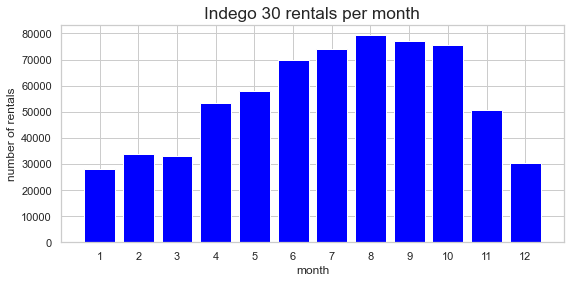

In [40]:
# Create Bar Chart for monthly rides with Indego 30
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indego30["month"], df_months_indego30["n_rides"], color = 'blue')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego 30 rentals per month", size = 'x-large')
plt.show()

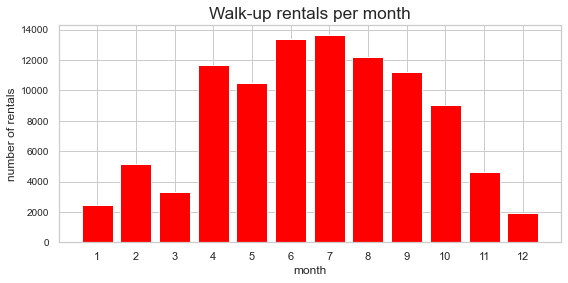

In [41]:
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_walkup["month"], df_months_walkup["n_rides"], color = 'red')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Walk-up rentals per month", size = 'x-large')
plt.show()

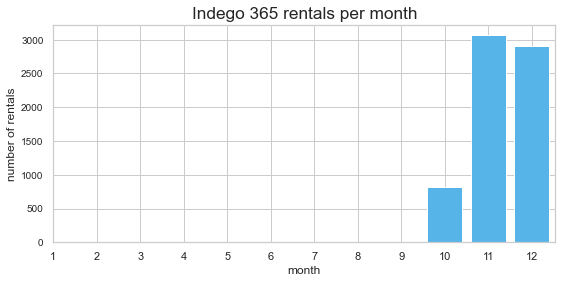

In [42]:
# Create Bar Chart for monthly rides with Indego 365
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indego365["month"], df_months_indego365["n_rides"], color = 'c')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego 365 rentals per month", size = 'x-large')
plt.show()

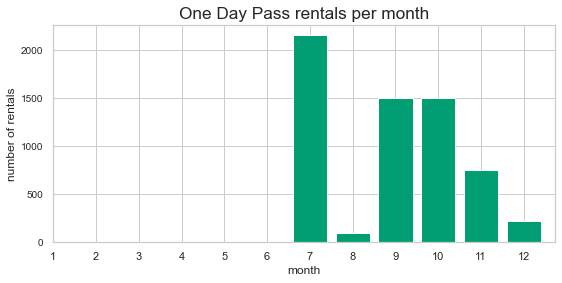

In [43]:
# Create Bar Chart for monthly rides with One Day Pass
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_onedaypass["month"], df_months_onedaypass["n_rides"], color = 'g')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("One Day Pass rentals per month", size = 'x-large')
plt.show()

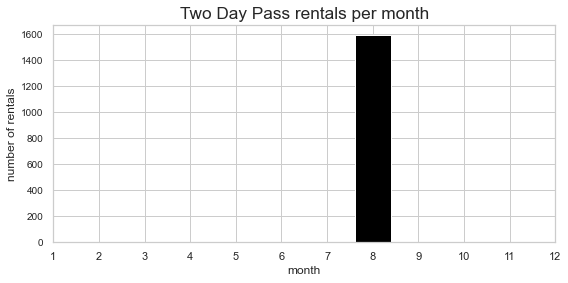

In [44]:
# Create Bar Chart for monthly rides with Two Day Pass
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_twodaypass["month"], df_months_twodaypass["n_rides"], color = 'black')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Two Day Pass rentals per month", size = 'x-large')
plt.show()

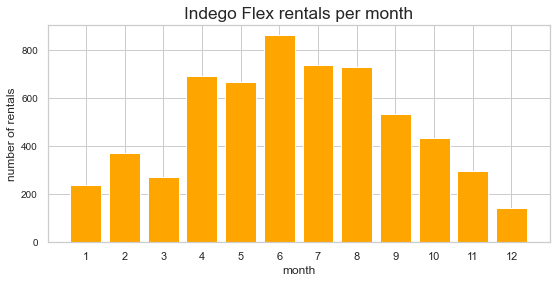

In [45]:
# Create Bar Chart for monthly rides with Indego Flex
fig = plt.figure(figsize=(9,4))
plt.bar(df_months_indegoflex["month"], df_months_indegoflex["n_rides"], color = 'orange')
plt.xticks(range(1,13))
plt.rc('ytick', labelsize = 10)
plt.xlabel("month", size = 'medium')
plt.ylabel("number of rentals", size = 'medium')
plt.title("Indego Flex rentals per month", size = 'x-large')
plt.show()

#### Analysis and Interpretation of the User Type Analysis:
The plots above all show that we the vast majority of rides (roughly 85%) are made using the Indego30 option, which is the a monthly subscription. This target audience should therefore be always be a special focus. The second largest portion is attributed to spontaneous Walk-up rides which make up circa. 12,5% The other are very minor compared to the monthly subscription services making up only around 2,5% of the total rides.
<br><br>Another result to note is that, the seasonality has a effect on the usage of the different payment models. Especially the One Day Pass is comparetively to other months especially popular during the summer. It can be assumed that this can be accounted to the increase in tourism during those months.
<br><br>The Two Day Pass is a special case as it was seemingly only offered in the month of August in 2017. The significant lower number of rides with the One Day Pass can also be explained with the popularity of the Two Day Pass in this month. 
<br><br>The annual subscription model Indigo 365 was seeminlgy only introduced in October, but is already a poular choice even rivaling the monthly subscription model Indigo 30 for the number of rides in December.
<br><br>Overall, we see a similiar monthly development for the options Indigo 30, Indego Flex and Walk-up which were available throughout the year. Based on these results you could increase the marketing of some of the Offers to either improve the usage or possibly stop some offers with low customer acceptance like Indego Flex.